In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time


In [2]:
INPUT_SEQUENCE_LENGTH = 168
OUTPUT_SEQUENCE_LENGTH = 72 

In [3]:
class ClassicalLSTMModel(nn.Module):
    """
    Builds a purely classical LSTM model for multi-step time-series forecasting.
    Predicts the next 3 days (72 hours) of air quality classes.
    """
    def __init__(self, n_features, n_lstm_units=4, num_layers=1, output_len=OUTPUT_SEQUENCE_LENGTH):
        super(ClassicalLSTMModel, self).__init__()
        
        # 1. Standard LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        # 2. Feed-Forward Classifier for multi-step prediction
        self.classifier = nn.Linear(n_lstm_units, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Pass through classifier to get predictions for all timesteps
        output = self.classifier(final_lstm_output)
        
        # 4. Apply sigmoid activation to get probabilities for each timestep
        return torch.sigmoid(output)

In [4]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_all_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_all_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_all_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")

    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'year', 'month', 'day', 'hour'])

    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'year', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')

    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")

    return df, feature_columns, le_location

In [5]:
def create_sequences_memory_efficient(df, feature_columns,
                                    input_len=INPUT_SEQUENCE_LENGTH,
                                    output_len=OUTPUT_SEQUENCE_LENGTH,
                                    stride=24):
    """
    Create sequences for multi-step forecasting.
    Input: `input_len` hours of data
    Output: `output_len` hours of predictions
    """
    print(f"Creating sequences with input length={input_len}, output length={output_len}...")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)

    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()

    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values

        # Calculate valid range to ensure we have enough data for output sequence
        max_start_idx = len(loc_df) - input_len - output_len

        for j in range(0, max_start_idx, stride):
            X_seq = loc_X.iloc[j : j + input_len].values
            # Get the next `output_len` hours of class data
            y_target = loc_y[j + input_len : j + input_len + output_len]

            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)

        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)

    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Input sequence shape: {X_sequences.shape}")
    print(f"Output sequence shape: {y_sequences.shape}")

    return X_sequences, y_sequences, location_indices, scaler

In [6]:
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model for multi-step forecasting."""
    print("Starting training with PyTorch...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0) * y_batch.size(1)

        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0) * y_batch.size(1)

        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        scheduler.step(val_loss)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_classical_lstm_model.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break

    model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
    return model, history

In [7]:
def plot_training_history(history):
    """Plot training history for multi-step forecasting"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    ylabel = 'Accuracy (per timestep)'
    plt.ylabel(ylabel)
    plt.legend()

    plt.tight_layout()
    plt.savefig('classical_training_history_multistep.png', dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        # Get predictions for first few test samples
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)

        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]

            # Get prediction
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            # Plot
            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, OUTPUT_SEQUENCE_LENGTH + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [9]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test):
    """Evaluate model to get accuracy per location and per hour"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)  # shape: (n_samples, 72)
    all_labels = np.concatenate(all_labels, axis=0)  # shape: (n_samples, 72)
    
    # Calculate accuracy per location
    unique_locations = np.unique(location_indices_test)
    location_acc = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc = all_preds[idx]
        labels_loc = all_labels[idx]
        acc = (preds_loc == labels_loc).mean()
        location_acc[loc] = acc
    
    # Calculate accuracy per hour
    hour_acc = np.zeros(OUTPUT_SEQUENCE_LENGTH)
    for hour in range(OUTPUT_SEQUENCE_LENGTH):
        preds_hour = all_preds[:, hour]
        labels_hour = all_labels[:, hour]
        hour_acc[hour] = (preds_hour == labels_hour).mean()
    
    return location_acc, hour_acc

In [10]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [11]:
df, feature_columns, le_location = load_and_prepare_data()

# Create sequences with configurable lengths
X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
    df, 
    feature_columns, 
    input_len=INPUT_SEQUENCE_LENGTH,
    output_len=OUTPUT_SEQUENCE_LENGTH,
    stride=24
)

# Split data
X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(
    X_sequences, y_sequences, location_indices, 
    test_size=0.2, random_state=42, stratify=location_indices
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")


Loading data...
Dataset shape: (14006400, 14)
Feature columns: ['PM25_MERRA2', 'DUCMASS', 'TOTANGSTR', 'DUFLUXV', 'SSFLUXV', 'DUFLUXU', 'BCCMASS', 'SSSMASS25', 'location_encoded']
Number of features: 9
Creating sequences with input length=168, output length=72...
Processed location 100/400
Processed location 200/400
Processed location 300/400
Processed location 400/400
Total sequences: 579600
Input sequence shape: (579600, 168, 9)
Output sequence shape: (579600, 72)
Training set shape: (463680, 168, 9)
Test set shape: (115920, 168, 9)
Training target shape: (463680, 72)
Test target shape: (115920, 72)


In [12]:
batch_size = 512

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Keep test data for evaluation
X_test_plot = X_test.copy()
y_test_plot = y_test.copy()

# Clean up memory
del X_sequences, y_sequences, location_indices, X_train, y_train, loc_train
gc.collect()

0

In [13]:
n_lstm_units = 128
num_layers = 4

model = ClassicalLSTMModel(
    n_features=len(feature_columns), 
    n_lstm_units=n_lstm_units,  
    num_layers=num_layers,
    output_len=OUTPUT_SEQUENCE_LENGTH
)
print("\nClassical LSTM Model Architecture:")
print(model)


Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=72, bias=True)
)


Starting training with PyTorch...
Epoch 1/25 - Loss: 0.0033, Acc: 0.8951 - Val Loss: 0.0033, Val Acc: 0.8980 - Duration: 146.40s
  -> Validation loss improved. Saving model.
Epoch 2/25 - Loss: 0.0033, Acc: 0.8973 - Val Loss: 0.0032, Val Acc: 0.8999 - Duration: 146.08s
  -> Validation loss improved. Saving model.
Epoch 3/25 - Loss: 0.0032, Acc: 0.8993 - Val Loss: 0.0032, Val Acc: 0.9009 - Duration: 146.00s
  -> Validation loss improved. Saving model.
Epoch 4/25 - Loss: 0.0032, Acc: 0.9010 - Val Loss: 0.0031, Val Acc: 0.9036 - Duration: 146.07s
  -> Validation loss improved. Saving model.
Epoch 5/25 - Loss: 0.0031, Acc: 0.9025 - Val Loss: 0.0031, Val Acc: 0.9048 - Duration: 146.11s
  -> Validation loss improved. Saving model.
Epoch 6/25 - Loss: 0.0031, Acc: 0.9040 - Val Loss: 0.0030, Val Acc: 0.9058 - Duration: 146.02s
  -> Validation loss improved. Saving model.
Epoch 7/25 - Loss: 0.0030, Acc: 0.9054 - Val Loss: 0.0030, Val Acc: 0.9074 - Duration: 146.08s
  -> Validation loss improved. 

/tmp/ipykernel_52233/112353104.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


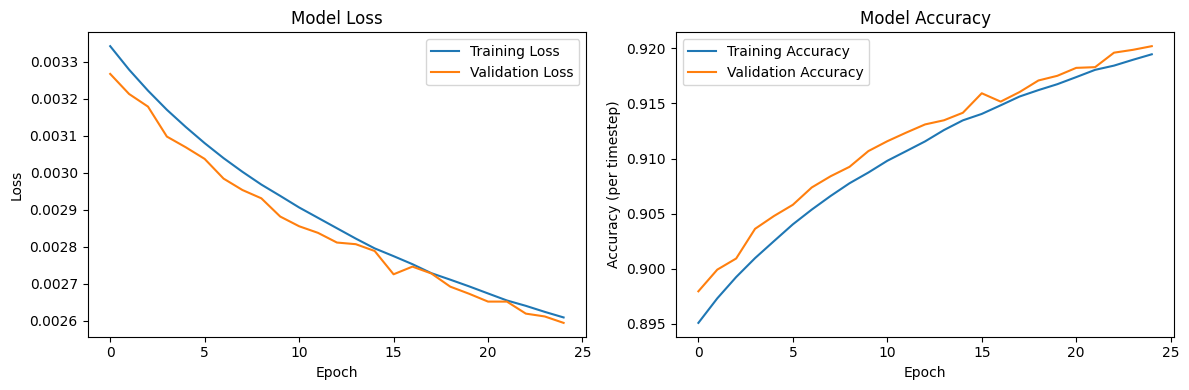

In [15]:
model, history = train_model_pytorch(model, train_loader, val_loader, epochs=25, patience=5)

plot_training_history(history)

In [16]:
n_lstm_units = 128
num_layers = 4

model = ClassicalLSTMModel(
    n_features=len(feature_columns), 
    n_lstm_units=n_lstm_units,  
    num_layers=num_layers,
    output_len=OUTPUT_SEQUENCE_LENGTH
)
model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
print("\nClassical LSTM Model Architecture:")
print(model)


Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=72, bias=True)
)


/tmp/ipykernel_52233/2814248130.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


In [17]:
model, history_2 = train_model_pytorch(model, train_loader, val_loader, epochs=25, patience=5)

Starting training with PyTorch...
Epoch 1/25 - Loss: 0.0026, Acc: 0.9198 - Val Loss: 0.0026, Val Acc: 0.9199 - Duration: 145.19s
  -> Validation loss improved. Saving model.
Epoch 2/25 - Loss: 0.0026, Acc: 0.9205 - Val Loss: 0.0026, Val Acc: 0.9211 - Duration: 145.35s
  -> Validation loss improved. Saving model.
Epoch 3/25 - Loss: 0.0026, Acc: 0.9210 - Val Loss: 0.0026, Val Acc: 0.9216 - Duration: 146.05s
  -> Validation loss improved. Saving model.
Epoch 4/25 - Loss: 0.0026, Acc: 0.9213 - Val Loss: 0.0025, Val Acc: 0.9220 - Duration: 146.18s
  -> Validation loss improved. Saving model.
Epoch 5/25 - Loss: 0.0025, Acc: 0.9218 - Val Loss: 0.0025, Val Acc: 0.9226 - Duration: 146.15s
  -> Validation loss improved. Saving model.
Epoch 6/25 - Loss: 0.0025, Acc: 0.9221 - Val Loss: 0.0025, Val Acc: 0.9226 - Duration: 146.06s
Epoch 7/25 - Loss: 0.0025, Acc: 0.9224 - Val Loss: 0.0025, Val Acc: 0.9233 - Duration: 146.31s
  -> Validation loss improved. Saving model.
Epoch 8/25 - Loss: 0.0025, Acc:

/tmp/ipykernel_52233/112353104.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


In [25]:
def concat_histories(h1, h2):
    merged = defaultdict(list)
    for k in set(h1) | set(h2):   # union of keys
        merged[k].extend(h1.get(k, []))
        merged[k].extend(h2.get(k, []))
    return merged

merged_history = concat_histories(history, history_2)

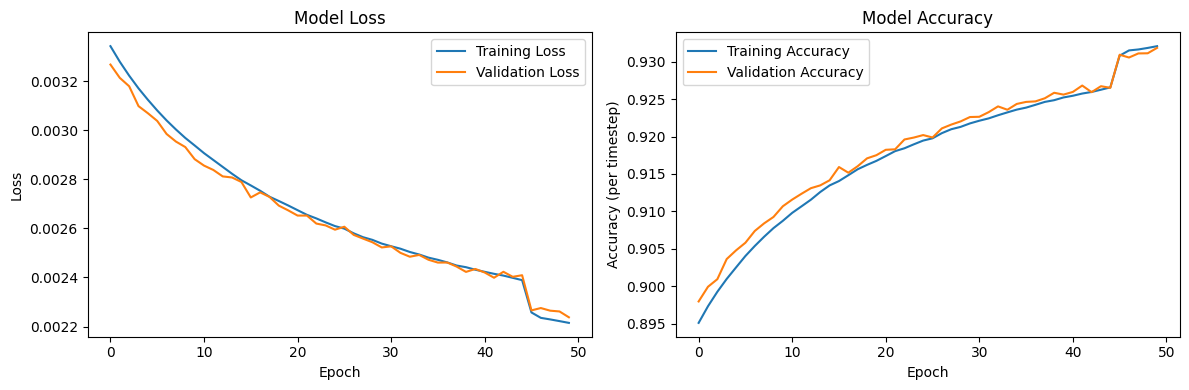

In [26]:
plot_training_history(merged_history)

In [29]:
print("\nCalculating detailed accuracy metrics...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model per location and per hour
location_acc, hour_acc = evaluate_model_per_location_and_hour(
    model, val_loader, device, loc_test
)


Calculating detailed accuracy metrics...


In [30]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_acc.keys()):
    print(f"Location {loc}: {location_acc[loc]:.4f}")


Per-location accuracy (averaged over all 72 hours):
Location 0: 0.9347
Location 1: 0.9424
Location 2: 0.9427
Location 3: 0.9221
Location 4: 0.9208
Location 5: 0.9355
Location 6: 0.9475
Location 7: 0.9555
Location 8: 0.9561
Location 9: 0.9597
Location 10: 0.9551
Location 11: 0.9398
Location 12: 0.9278
Location 13: 0.9274
Location 14: 0.9132
Location 15: 0.9058
Location 16: 0.8941
Location 17: 0.8721
Location 18: 0.8858
Location 19: 0.9143
Location 20: 0.9379
Location 21: 0.9598
Location 22: 0.9540
Location 23: 0.9317
Location 24: 0.9215
Location 25: 0.9451
Location 26: 0.9539
Location 27: 0.9561
Location 28: 0.9650
Location 29: 0.9615
Location 30: 0.9545
Location 31: 0.9459
Location 32: 0.9403
Location 33: 0.9373
Location 34: 0.9204
Location 35: 0.9146
Location 36: 0.8992
Location 37: 0.8827
Location 38: 0.9079
Location 39: 0.9365
Location 40: 0.9431
Location 41: 0.9562
Location 42: 0.9568
Location 43: 0.9432
Location 44: 0.9215
Location 45: 0.9405
Location 46: 0.9532
Location 47: 0.95

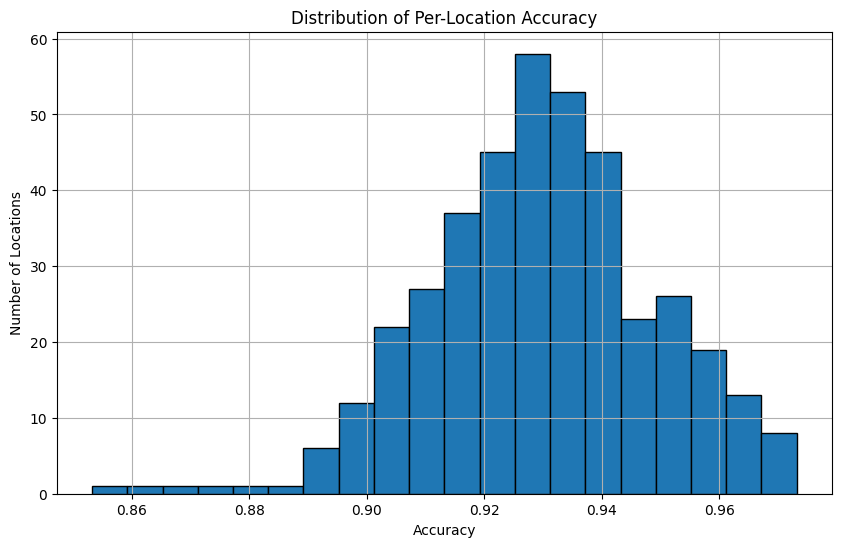

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(list(location_acc.values()), bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour in range(OUTPUT_SEQUENCE_LENGTH):
    print(f"Hour {hour+1}: {hour_acc[hour]:.4f}")


Per-hour accuracy (averaged over all locations):
Hour 1: 0.9810
Hour 2: 0.9748
Hour 3: 0.9636
Hour 4: 0.9514
Hour 5: 0.9415
Hour 6: 0.9337
Hour 7: 0.9212
Hour 8: 0.9199
Hour 9: 0.9278
Hour 10: 0.9335
Hour 11: 0.9409
Hour 12: 0.9424
Hour 13: 0.9369
Hour 14: 0.9388
Hour 15: 0.9378
Hour 16: 0.9329
Hour 17: 0.9263
Hour 18: 0.9241
Hour 19: 0.9235
Hour 20: 0.9264
Hour 21: 0.9274
Hour 22: 0.9286
Hour 23: 0.9288
Hour 24: 0.9300
Hour 25: 0.9291
Hour 26: 0.9292
Hour 27: 0.9289
Hour 28: 0.9289
Hour 29: 0.9281
Hour 30: 0.9258
Hour 31: 0.9170
Hour 32: 0.9178
Hour 33: 0.9241
Hour 34: 0.9327
Hour 35: 0.9402
Hour 36: 0.9415
Hour 37: 0.9376
Hour 38: 0.9406
Hour 39: 0.9397
Hour 40: 0.9333
Hour 41: 0.9260
Hour 42: 0.9249
Hour 43: 0.9249
Hour 44: 0.9263
Hour 45: 0.9280
Hour 46: 0.9272
Hour 47: 0.9282
Hour 48: 0.9281
Hour 49: 0.9283
Hour 50: 0.9276
Hour 51: 0.9275
Hour 52: 0.9268
Hour 53: 0.9251
Hour 54: 0.9201
Hour 55: 0.9098
Hour 56: 0.9090
Hour 57: 0.9169
Hour 58: 0.9258
Hour 59: 0.9336
Hour 60: 0.9354

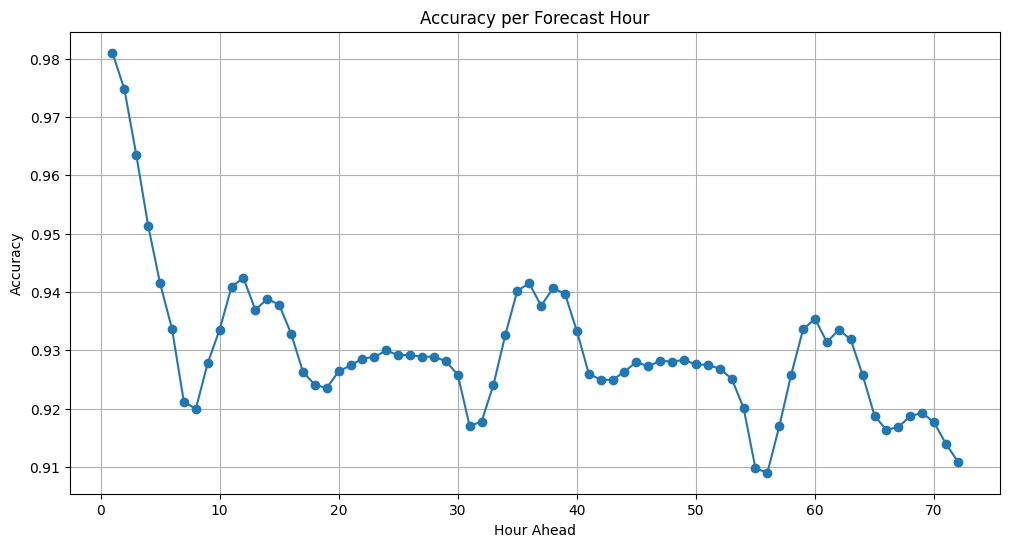

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, OUTPUT_SEQUENCE_LENGTH + 1), hour_acc, marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Generating example predictions...


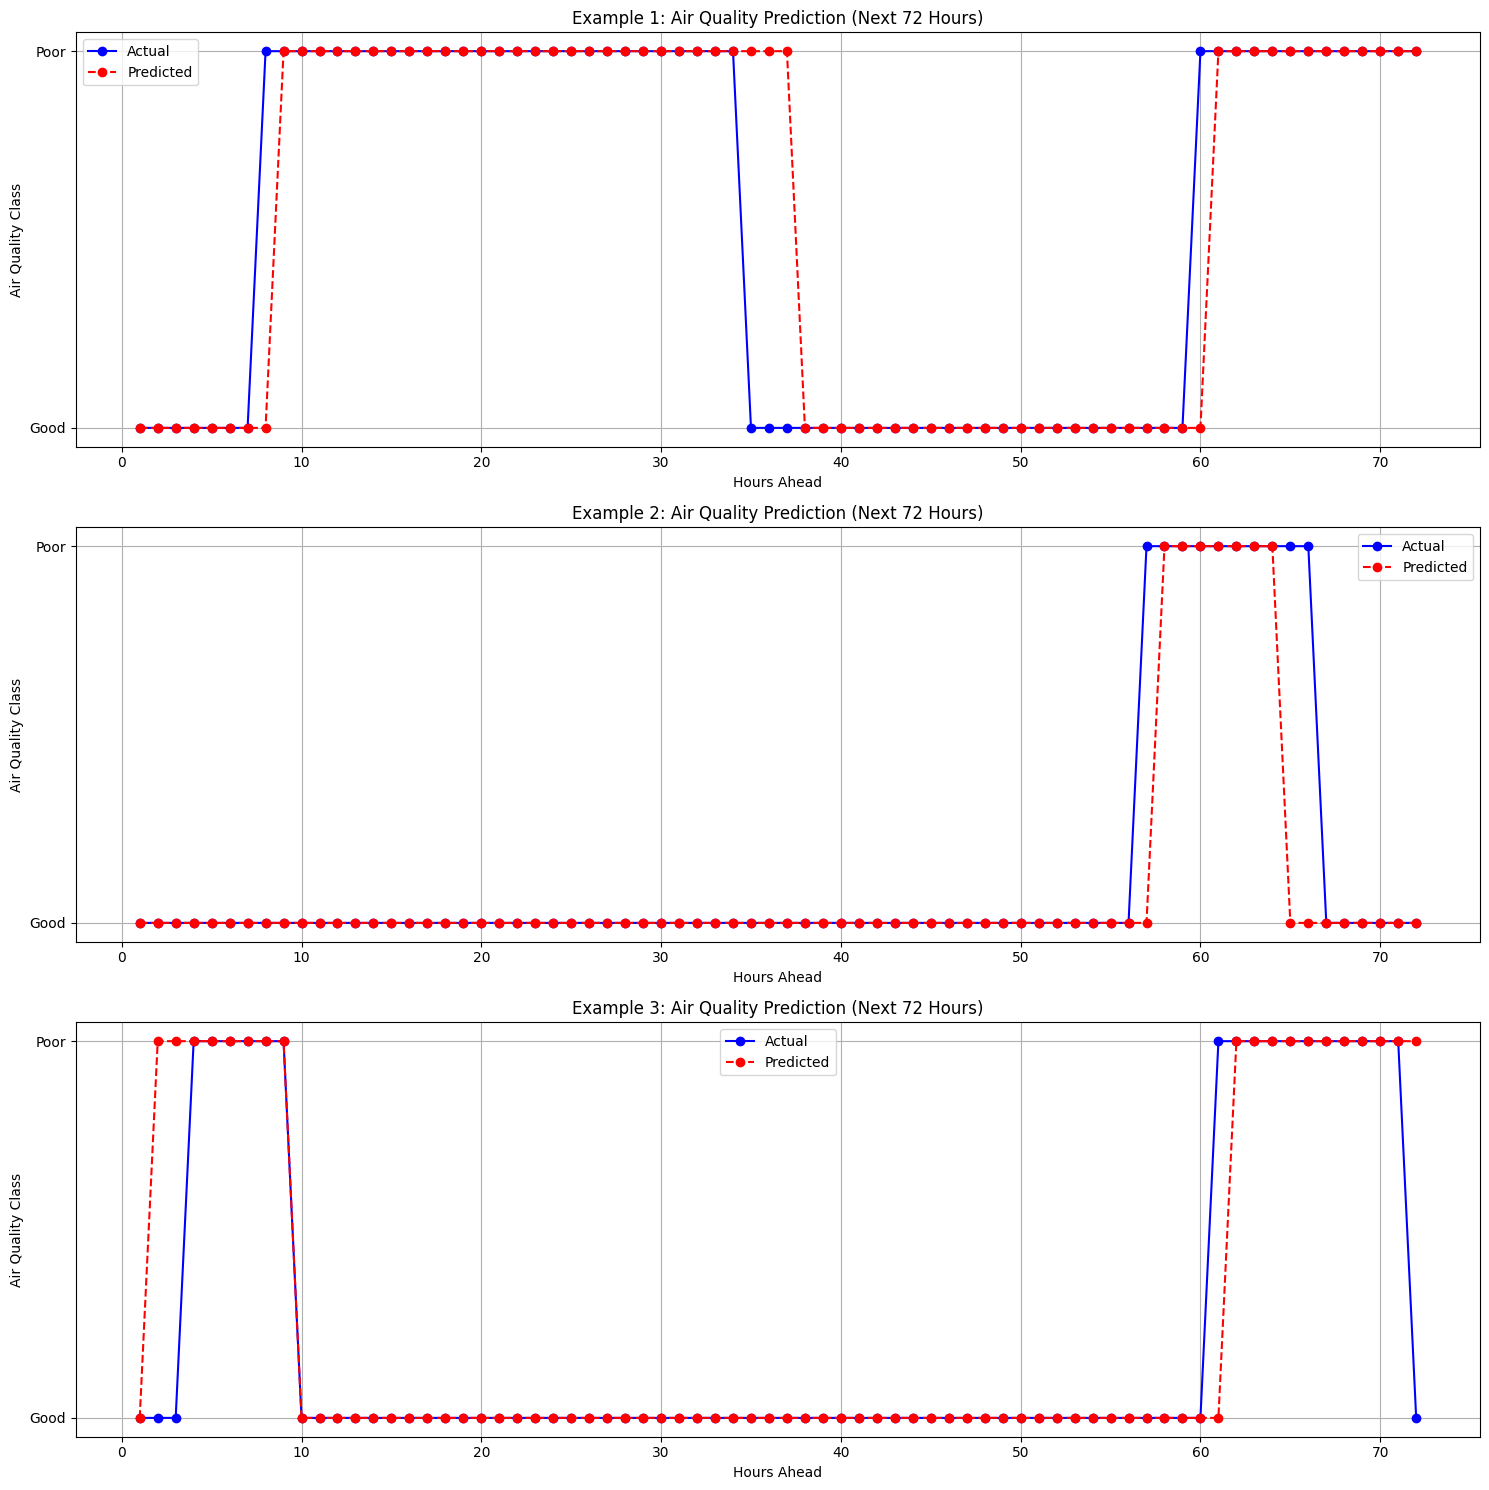

In [35]:
print("\nGenerating example predictions...")
plot_example_predictions(model, X_test_plot, y_test_plot, num_examples=3)